In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
data=pd.read_csv('/content/cleaned_data_telecomchurn.csv')

In [142]:
data[['registration_year', 'registration_month', 'registration_day','num_dependents','single or not']].head()

,registration_year,registration_month,registration_day,num_dependents,single or not
0,2020,1,1,4,Not single
1,2020,1,1,2,Not single
2,2020,1,1,0,Single
3,2020,1,1,1,Not single
4,2020,1,1,2,Not single


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243553 entries, 0 to 243552
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           243553 non-null  int64 
 1   telecom_partner      243553 non-null  object
 2   gender               243553 non-null  object
 3   age                  243553 non-null  int64 
 4   age_decay_range      243553 non-null  int64 
 5   age_interval         243553 non-null  object
 6   state                243553 non-null  object
 7   city                 243553 non-null  object
 8   region               243553 non-null  object
 9   registration_year    243553 non-null  int64 
 10  registration_month   243553 non-null  int64 
 11  registration_day     243553 non-null  int64 
 12  num_dependents       243553 non-null  int64 
 13  single or not        243553 non-null  object
 14  estimated_salary     243553 non-null  int64 
 15  calls_made           243553 non-nu

In [144]:
data_scaled = data.copy()

In [145]:
#Encode 'single or not': Single = 1, Not single = 0
data_scaled['single_or_not_encoded'] = data_scaled['single or not'].map({'Single': 1, 'Not single': 0})

In [146]:
data_scaled[['single or not']].value_counts()

,count
single or not,
Not single,194626
Single,48927


In [147]:
data_scaled[['single or not', 'single_or_not_encoded']].head()

,single or not,single_or_not_encoded
0,Not single,0
1,Not single,0
2,Single,1
3,Not single,0
4,Not single,0


In [148]:
registration_data = data[['registration_year', 'registration_month', 'registration_day']].rename(
    columns={
        'registration_year': 'year',
        'registration_month': 'month',
        'registration_day': 'day'
    }
)
data['registration_date'] = pd.to_datetime(registration_data[['year', 'month', 'day']])

In [149]:
# 2. Extract useful features from registration_date
data['registration_dayofweek'] = data['registration_date'].dt.dayofweek  # Monday=0, Sunday=6
data['registration_dayofyear'] = data['registration_date'].dt.dayofyear
data['days_since_registration'] = (pd.to_datetime("today") - data['registration_date']).dt.days

In [150]:
# 3. Choose numeric columns for standardization (excluding ID columns and target)
numeric_cols = ['registration_dayofweek', 'registration_dayofyear', 'days_since_registration']

In [151]:
# Apply Standardization
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [152]:
# Show the transformed features
data_scaled[numeric_cols + ['churn']].head()

,registration_dayofweek,registration_dayofyear,days_since_registration,churn
0,-0.499736,-1.587525,1.730623,0
1,-0.499736,-1.587525,1.730623,0
2,-0.499736,-1.587525,1.730623,1
3,-0.499736,-1.587525,1.730623,1
4,-0.499736,-1.587525,1.730623,0


In [153]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [154]:

# 3. Select features and target
data_scaled['single_or_not_encoded'] = data_scaled['single or not'].map({'Single': 1, 'Not single': 0})
X = data_scaled[['age', 'num_dependents', 'single_or_not_encoded',
                'estimated_salary', 'calls_made', 'sms_sent', 'data_used',
                'registration_dayofweek', 'registration_dayofyear',
                'days_since_registration']]
y = data_scaled['churn']



In [155]:
# 4. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
print("NaN values in y:", y.isna().sum())


NaN values in y: 0


In [157]:
# 6. Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

In [158]:
# Check for NaN in target
print("NaN count in y_train:", y_train.isna().sum())

# Check for NaN in features
print("NaN count in X_train:\n", X_train.isna().sum())

# Remove rows with NaN in either X_train or y_train
nan_mask = y_train.isna() | X_train.isna().any(axis=1)
X_train_clean = X_train[~nan_mask]
y_train_clean = y_train[~nan_mask]

NaN count in y_train: 0
NaN count in X_train:
 age                        0
num_dependents             0
single_or_not_encoded      0
estimated_salary           0
calls_made                 0
sms_sent                   0
data_used                  0
registration_dayofweek     0
registration_dayofyear     0
days_since_registration    0
dtype: int64


In [159]:
assert not y_train_clean.isna().any(), "NaN still present in y_train!"
assert not X_train_clean.isna().any().any(), "NaN still present in X_train!"

In [160]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_clean, y_train_clean)

# Verify class balance
print("Class distribution after SMOTE:\n", pd.Series(y_res).value_counts())

Class distribution after SMOTE:
 churn
1    155798
0    155798
Name: count, dtype: int64


In [161]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(
    #  class_weight='balanced',  # Optional but recommended
    max_iter=1000,
    random_state=42
)
logreg.fit(X_res, y_res)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.61      0.69     38928
           1       0.20      0.39      0.26      9783

    accuracy                           0.57     48711
   macro avg       0.50      0.50      0.48     48711
weighted avg       0.68      0.57      0.61     48711


Confusion Matrix:


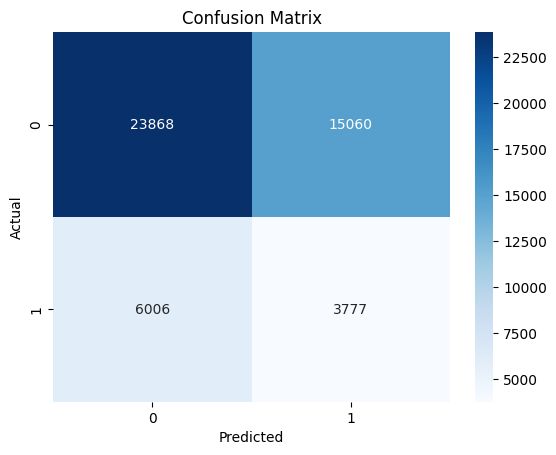

In [162]:
# 7. Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [163]:
# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")



Accuracy: 0.5675


In [164]:
# Calculate and print ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.4985


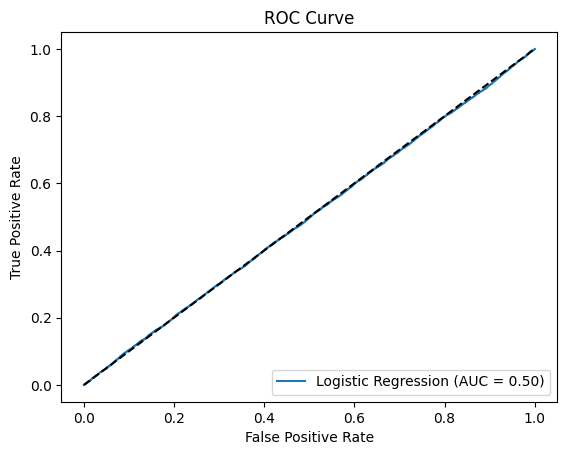

In [165]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [166]:
# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': logreg.coef_[0]
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance)


Feature Importance:
                   Feature  Importance
0                      age    0.005554
8   registration_dayofyear    0.005087
4               calls_made    0.001642
5                 sms_sent    0.000220
6                data_used    0.000024
3         estimated_salary    0.000002
9  days_since_registration   -0.008449
7   registration_dayofweek   -0.008603
1           num_dependents   -0.411927
2    single_or_not_encoded   -1.988306
